# Blood Cell Classification Using CNNs and RNNs

The model architecture will consist of convolutional neural networks (CNN) and a recurrent neural network (RNN) used for feature extraction and a Fully-Connected Layer used for classification and predicting the final output. A CNN-based architecture would be sufficient for the image classification problem. However, recent research suggests that implementing a RNN for feature extraction in parallel to the CNN results in a mimicry of biological neural networks which learn through sequential data.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

### Transfer Learning with VGG-16 for CNN Branch
From a wide range of pre-trained CNNs available, this project will be using the VGG-16 CNN to initialize parameters of the model's first CNN layer through transfer learning. In a past research paper that discussed the recognition of blood cell types using CNNs, two different pre-trained CNN layers were used to supply the first CNN layer with initial parameters. There, the VGG-16 CNN resulted in a higher accuracy compared to the Inceptionv3 network. The VGG-16 CNN has been trained on over 1 million images from ImageNet and has proven to be applicable to a range of other image classification projects through transfer learning

In [2]:
import torchvision.models

# vgg16 = torchvision.models.vgg16(pretrained = True)
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
torch.manual_seed(1)

In [4]:
#only want the filter weights, not the classifier
convalexnet = alexnet.features

convalexnet #output channels is 512

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

### Main Model

**CNN Layers for Feature Extraction**

The first branch is the CNN branch used for feature extraction. Multiple layers of CNN and pooling will be used for feature extraction. The kernel matrix that scans over the image pixels will be used to extract features from the image such as edges. Each convolutional layer will be followed by a pooling layer, which will employ *Max or Average Pooling* to reduce the size of the image and extract the dominant features. At the end of the CNN branch, a feature map will be produced to pass to the Fully-Connected Layer.

**RNN Layer for Feature Extraction**

The RNN branch of the model is used for higher-level feature extraction, by taking advantage of its ability to store memory of previous inputs in cells that can be used to provide context to future data. This project will be using the Gated Recurrent Unit architecture for RNNs, that uses hidden states for high-level feature extraction through the implementation of a Reset and Update Gate.

**Fully-Connected Layer**

The inputs to the Fully-Connected Layer are the merged features learned from the CNN and RNN branches of the model. These features are then flattened, connected, and passed into the Softmax function for classification. The output will be the predicted label of the blood cell image.

**Current Progress on the Primary Model**

Implementation of Transfer Learning with VGG-16, CNN Branch, and Fully-Connected Layer is complete. 

Next step is to incorporate the RNN branch parallel to the CNN branch to improve the model.

In [5]:
class cnn_test(nn.Module):
    def __init__(self):
        super(cnn_test, self).__init__()
        self.fc = nn.Linear(256*7*7, 8) #temp sizes, idk what the dimensions should be
        #also how many classes are there?

    def forward(self, x):
        cnnpath = x.view(-1, 256*7*7) #x = x.view(-1, 512*8*8) #maybe this one? but idk dimensions
        x=self.fc(cnnpath)
        return x

In [6]:
cnntest = cnn_test()

In [7]:
use_cuda=False

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/APS360 Project Team/Data/Blood_Cell_Dataset_Small_Split.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [10]:
import torchvision.transforms as transforms

In [11]:
transform = transforms.Compose(
        [ #resize all images to height and width of 280
         transforms.ToTensor()        #transform images to tensors
         ])

classes = ('basophil', 'neutrophil', 'ig', 'monocyte', 
               'eosinophil', 'erythroblast', 'lymphocyte', 'platelet')

train_data = torchvision.datasets.ImageFolder("/tmp/content/Blood_Cell_Dataset_Small_Split/train", transform=transform)
val_data = torchvision.datasets.ImageFolder("/tmp/content/Blood_Cell_Dataset_Small_Split/val", transform=transform)
test_data = torchvision.datasets.ImageFolder("/tmp/content/Blood_Cell_Dataset_Small_Split/test", transform=transform)
#test_dataset = torchvision.datasets.ImageFolder(test_folder, transform=transform)
print(len(train_data), len(val_data), len(test_data))

1600 200 200


In [13]:
import torch.utils.data

In [14]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, num_workers=0, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=10, num_workers=0, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=10, num_workers=0, shuffle=True)

In [15]:
train_features = []

for i in enumerate(train_loader, 0):
  dataiter = iter(train_loader)
  images, labels = next(dataiter)
  # images = images.cuda()
  # labels = labels.cuda()
  train_features.append([convalexnet(images), labels])

In [16]:
val_features = []

for i in enumerate(val_loader, 0):
  dataiter = iter(val_loader)
  images, labels = next(dataiter)
  # images = images.cuda()
  # labels = labels.cuda()
  val_features.append([convalexnet(images), labels])

In [20]:
test_features = []

for i in enumerate(test_loader, 0):
  dataiter = iter(test_loader)
  images, labels = next(dataiter)
  # images = images.cuda()
  # labels = labels.cuda()
  test_features.append([convalexnet(images), labels])

In [20]:
def get_accuracy_transfer(model, train=True):
    
    if train == True:
      data = train_features
    else:
      data = val_features

    correct = 0
    total = 0
    for feature in data:
        #feature[0] is the features extracted, features[1] is the label
        output = model(feature[0])
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(feature[1].view_as(pred)).sum().item()
        total += feature[0].shape[0]
    return correct / total

In [25]:
import time
import matplotlib.pyplot as plt


def train_transfer(model, data, batch_size=20, lr=0.01, num_epochs=2):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        Mini_batch_total = 0
        for feature in train_features:

            feature[0] = torch.from_numpy(feature[0].detach().numpy())
            out = model(feature[0])             # forward pass
            loss = criterion(out, feature[1]) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch



            ##### Mini_batch Accuracy ##### We don't compute accuracy on the whole training set in every iteration!
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(feature[1].view_as(pred)).sum().item()
            Mini_batch_total = feature[0].shape[0]
            train_acc.append((mini_batch_correct / Mini_batch_total))
           ###########################

          # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy_transfer(model, train=False))  # compute validation accuracy
            n += 1
            mini_b += 1
            #print("Iteration: ",n,'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))


        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))


    end_time= time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")    
    plt.xlabel("Iterations")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy_transfer(model, train=True))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))
    

Epoch 0 Finished.  Time per Epoch:   0.77 s 
Epoch 1 Finished.  Time per Epoch:   0.75 s 
Epoch 2 Finished.  Time per Epoch:   0.75 s 
Epoch 3 Finished.  Time per Epoch:   0.74 s 
Epoch 4 Finished.  Time per Epoch:   0.73 s 
Epoch 5 Finished.  Time per Epoch:   0.73 s 
Epoch 6 Finished.  Time per Epoch:   0.74 s 
Epoch 7 Finished.  Time per Epoch:   0.77 s 
Epoch 8 Finished.  Time per Epoch:   0.79 s 
Epoch 9 Finished.  Time per Epoch:   0.81 s 
Epoch 10 Finished.  Time per Epoch:   0.82 s 
Epoch 11 Finished.  Time per Epoch:   0.82 s 
Epoch 12 Finished.  Time per Epoch:   0.82 s 
Epoch 13 Finished.  Time per Epoch:   0.81 s 
Epoch 14 Finished.  Time per Epoch:   0.81 s 
Epoch 15 Finished.  Time per Epoch:   0.81 s 
Epoch 16 Finished.  Time per Epoch:   0.81 s 
Epoch 17 Finished.  Time per Epoch:   0.81 s 
Epoch 18 Finished.  Time per Epoch:   0.80 s 
Epoch 19 Finished.  Time per Epoch:   0.80 s 
Epoch 20 Finished.  Time per Epoch:   0.80 s 
Epoch 21 Finished.  Time per Epoch:   0.80 s

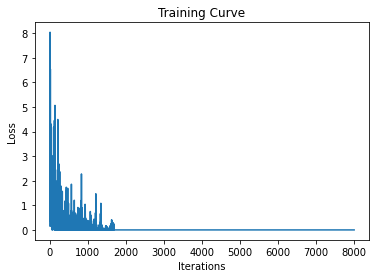

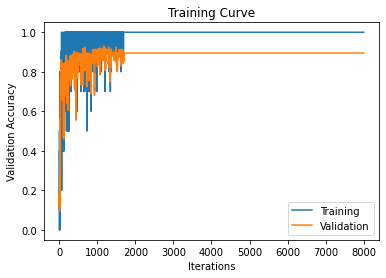

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.895
Total time:   42.53 s  Time per Epoch:   0.85 s 


In [21]:
train_transfer(cnntest, train_data, 10, ,0.01, 50)

In [22]:
class cnn_test_two(nn.Module):
    def __init__(self):
        super(cnn_test_two, self).__init__()
        self.fc1 = nn.Linear(256*7*7, 64) #temp sizes, idk what the dimensions should be
        self.fc2 = nn.Linear(64, 8)

    def forward(self, x):
        cnnpath = x.view(-1, 256*7*7) #x = x.view(-1, 512*8*8) #maybe this one? but idk dimensions
        x = F.relu(self.fc1(cnnpath))
        x = self.fc2(x)
        return x

Epoch 0 Finished.  Time per Epoch:   3.04 s 
Epoch 1 Finished.  Time per Epoch:   3.19 s 
Epoch 2 Finished.  Time per Epoch:   3.22 s 
Epoch 3 Finished.  Time per Epoch:   3.16 s 
Epoch 4 Finished.  Time per Epoch:   3.18 s 
Epoch 5 Finished.  Time per Epoch:   3.45 s 
Epoch 6 Finished.  Time per Epoch:   3.65 s 
Epoch 7 Finished.  Time per Epoch:   3.76 s 
Epoch 8 Finished.  Time per Epoch:   3.88 s 
Epoch 9 Finished.  Time per Epoch:   3.99 s 
Epoch 10 Finished.  Time per Epoch:   4.04 s 
Epoch 11 Finished.  Time per Epoch:   4.10 s 
Epoch 12 Finished.  Time per Epoch:   4.15 s 
Epoch 13 Finished.  Time per Epoch:   4.18 s 
Epoch 14 Finished.  Time per Epoch:   4.23 s 


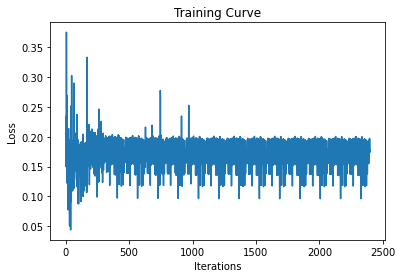

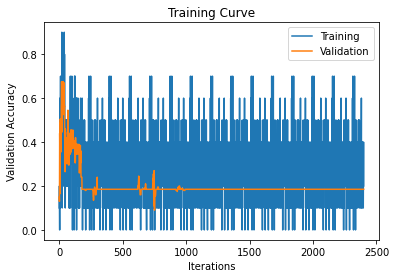

Final Training Accuracy: 0.2625
Final Validation Accuracy: 0.185
Total time:   63.38 s  Time per Epoch:   4.23 s 


In [23]:
cnntest_two = cnn_test_two()

train_transfer(cnntest_two, train_data, 10, 0.01, 15)

Epoch 0 Finished.  Time per Epoch:   3.73 s 
Epoch 1 Finished.  Time per Epoch:   3.38 s 
Epoch 2 Finished.  Time per Epoch:   3.37 s 
Epoch 3 Finished.  Time per Epoch:   3.29 s 
Epoch 4 Finished.  Time per Epoch:   3.22 s 
Epoch 5 Finished.  Time per Epoch:   3.18 s 
Epoch 6 Finished.  Time per Epoch:   3.18 s 
Epoch 7 Finished.  Time per Epoch:   3.21 s 
Epoch 8 Finished.  Time per Epoch:   3.18 s 
Epoch 9 Finished.  Time per Epoch:   3.16 s 
Epoch 10 Finished.  Time per Epoch:   3.15 s 
Epoch 11 Finished.  Time per Epoch:   3.17 s 
Epoch 12 Finished.  Time per Epoch:   3.21 s 
Epoch 13 Finished.  Time per Epoch:   3.24 s 
Epoch 14 Finished.  Time per Epoch:   3.23 s 
Epoch 15 Finished.  Time per Epoch:   3.22 s 
Epoch 16 Finished.  Time per Epoch:   3.24 s 
Epoch 17 Finished.  Time per Epoch:   3.22 s 
Epoch 18 Finished.  Time per Epoch:   3.21 s 
Epoch 19 Finished.  Time per Epoch:   3.20 s 
Epoch 20 Finished.  Time per Epoch:   3.21 s 
Epoch 21 Finished.  Time per Epoch:   3.21 s

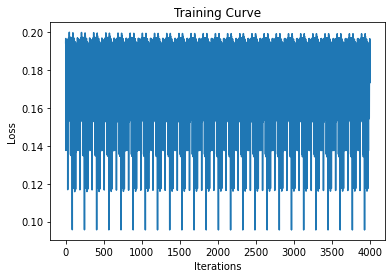

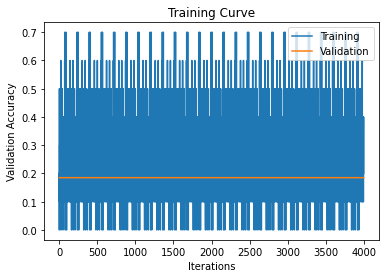

Final Training Accuracy: 0.2625
Final Validation Accuracy: 0.185
Total time:   79.72 s  Time per Epoch:   3.19 s 


In [26]:
cnntest_three = cnn_test_two()

train_transfer(cnntest_two, train_data, 10, 0.001, 25)

Epoch 0 Finished.  Time per Epoch:   0.60 s 
Epoch 1 Finished.  Time per Epoch:   0.59 s 
Epoch 2 Finished.  Time per Epoch:   0.58 s 
Epoch 3 Finished.  Time per Epoch:   0.58 s 
Epoch 4 Finished.  Time per Epoch:   0.58 s 
Epoch 5 Finished.  Time per Epoch:   0.58 s 
Epoch 6 Finished.  Time per Epoch:   0.58 s 
Epoch 7 Finished.  Time per Epoch:   0.58 s 
Epoch 8 Finished.  Time per Epoch:   0.57 s 
Epoch 9 Finished.  Time per Epoch:   0.57 s 
Epoch 10 Finished.  Time per Epoch:   0.57 s 
Epoch 11 Finished.  Time per Epoch:   0.57 s 
Epoch 12 Finished.  Time per Epoch:   0.57 s 
Epoch 13 Finished.  Time per Epoch:   0.57 s 
Epoch 14 Finished.  Time per Epoch:   0.58 s 
Epoch 15 Finished.  Time per Epoch:   0.58 s 
Epoch 16 Finished.  Time per Epoch:   0.59 s 
Epoch 17 Finished.  Time per Epoch:   0.60 s 
Epoch 18 Finished.  Time per Epoch:   0.61 s 
Epoch 19 Finished.  Time per Epoch:   0.62 s 
Epoch 20 Finished.  Time per Epoch:   0.63 s 
Epoch 21 Finished.  Time per Epoch:   0.63 s

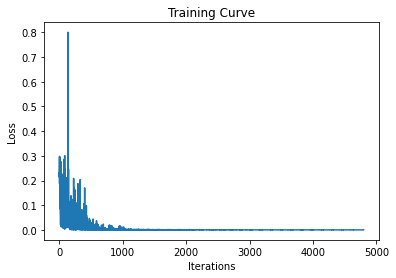

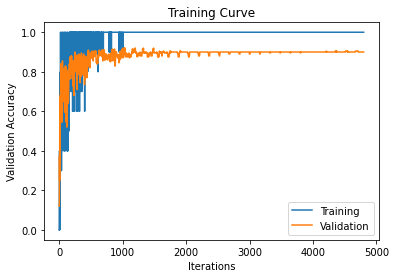

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.9
Total time:   18.45 s  Time per Epoch:   0.62 s 


In [27]:
cnntest_four = cnn_test()

train_transfer(cnntest_four, train_data, 10, 0.001, 30)

Epoch 0 Finished.  Time per Epoch:   0.57 s 
Epoch 1 Finished.  Time per Epoch:   0.57 s 
Epoch 2 Finished.  Time per Epoch:   0.58 s 
Epoch 3 Finished.  Time per Epoch:   0.58 s 
Epoch 4 Finished.  Time per Epoch:   0.61 s 
Epoch 5 Finished.  Time per Epoch:   0.64 s 
Epoch 6 Finished.  Time per Epoch:   0.66 s 
Epoch 7 Finished.  Time per Epoch:   0.67 s 
Epoch 8 Finished.  Time per Epoch:   0.68 s 
Epoch 9 Finished.  Time per Epoch:   0.70 s 
Epoch 10 Finished.  Time per Epoch:   0.69 s 
Epoch 11 Finished.  Time per Epoch:   0.68 s 
Epoch 12 Finished.  Time per Epoch:   0.67 s 
Epoch 13 Finished.  Time per Epoch:   0.66 s 
Epoch 14 Finished.  Time per Epoch:   0.65 s 


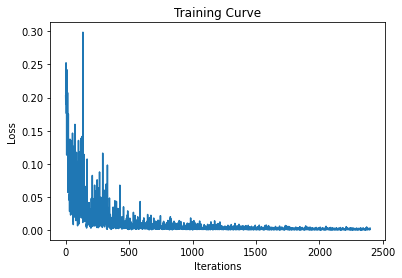

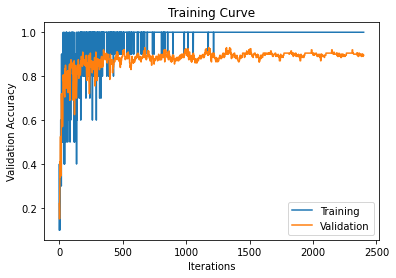

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.895
Total time:    9.79 s  Time per Epoch:   0.65 s 


In [28]:
cnntest_five = cnn_test()

train_transfer(cnntest_five, train_data, 10, 0.0005, 15)

In [32]:
print(test_data.class_to_idx)

print(test_data.imgs)

{'basophil': 0, 'eosinophil': 1, 'erythroblast': 2, 'ig': 3, 'lymphocyte': 4, 'monocyte': 5, 'neutrophil': 6, 'platelet': 7}
[('/tmp/content/Blood_Cell_Dataset_Small_Split/test/basophil/BA_145728.jpg', 0), ('/tmp/content/Blood_Cell_Dataset_Small_Split/test/basophil/BA_196745.jpg', 0), ('/tmp/content/Blood_Cell_Dataset_Small_Split/test/basophil/BA_271501.jpg', 0), ('/tmp/content/Blood_Cell_Dataset_Small_Split/test/basophil/BA_338836.jpg', 0), ('/tmp/content/Blood_Cell_Dataset_Small_Split/test/basophil/BA_372309.jpg', 0), ('/tmp/content/Blood_Cell_Dataset_Small_Split/test/basophil/BA_466566.jpg', 0), ('/tmp/content/Blood_Cell_Dataset_Small_Split/test/basophil/BA_478314.jpg', 0), ('/tmp/content/Blood_Cell_Dataset_Small_Split/test/basophil/BA_624477.jpg', 0), ('/tmp/content/Blood_Cell_Dataset_Small_Split/test/basophil/BA_664643.jpg', 0), ('/tmp/content/Blood_Cell_Dataset_Small_Split/test/basophil/BA_705969.jpg', 0), ('/tmp/content/Blood_Cell_Dataset_Small_Split/test/basophil/BA_84086.jpg',

In [40]:
# do class checking for platelet (smaller than other cells), neutrophil (odd shape), basophil (normal)
from torch.utils.data import DataLoader, Subset

basophil_dset = Subset(test_data, range(0, 25))
neutrophil_dset = Subset(test_data, range(150, 175))
platelet_dset = Subset(test_data, range(175, 200))

basophil_loader = torch.utils.data.DataLoader(basophil_dset, batch_size=10, num_workers=0, shuffle=True)
neutrophil_loader = torch.utils.data.DataLoader(neutrophil_dset, batch_size=10, num_workers=0, shuffle=True)
platelet_loader = torch.utils.data.DataLoader(platelet_dset, batch_size=10, num_workers=0, shuffle=True)

print(len(basophil_dset))
print(len(neutrophil_dset))
print(len(platelet_dset))

def get_accuracy_class(model, data):

    correct = 0
    total = 0
    for feature in data:
        #feature[0] is the features extracted, features[1] is the label
        output = model(feature[0])
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(feature[1].view_as(pred)).sum().item()
        total += feature[0].shape[0]
    return correct / total

basophil_features = []

for i in enumerate(basophil_loader, 0):
  dataiter = iter(basophil_loader)
  images, labels = next(dataiter)
  # images = images.cuda()
  # labels = labels.cuda()
  basophil_features.append([convalexnet(images), labels])

neutrophil_features = []

for i in enumerate(neutrophil_loader, 0):
  dataiter = iter(neutrophil_loader)
  images, labels = next(dataiter)
  # images = images.cuda()
  # labels = labels.cuda()
  neutrophil_features.append([convalexnet(images), labels])

platelet_features = []

for i in enumerate(platelet_loader, 0):
  dataiter = iter(platelet_loader)
  images, labels = next(dataiter)
  # images = images.cuda()
  # labels = labels.cuda()
  platelet_features.append([convalexnet(images), labels])

b_acc = get_accuracy_class(cnntest_four, basophil_features)
n_acc = get_accuracy_class(cnntest_four, neutrophil_features)
p_acc = get_accuracy_class(cnntest_four, platelet_features)

print("Basophil Test Accuracy:", b_acc)
print("Neutrophil Test Accuracy:", n_acc)
print("Platelet Test Accuracy:", p_acc)

25
25
25
Basophil Test Accuracy: 0.9333333333333333
Neutrophil Test Accuracy: 0.9
Platelet Test Accuracy: 1.0


### Extra Material - Needs Fixing

In [ ]:
class primary_model(nn.Module):
  def __init__(self, input_size, hidden_size, num_class):
    super(primary_model, self).__init__()
    self
    # write parallel RNN branch
    self.hidden_size = hidden_size
    self.rnn = nn.GRU(input_size, hidden_size, batch_first=True) # keep the original plan from proposal and use GRUs?
    self.fc = nn.Linear(hidden_size, num_class)
  def forward(self, x):
    # Set the initial hidden states
    h0 = torch.zeros(1, x.size(0), self.hidden_size)
    # Forward propagate the RNN
    out, __ = self.rnn(x, h0)
    # Pass the output of the last step to the classifier
    return self.fc(out[:,-1,:])

In [ ]:
class test(nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(test, self).__init__()
        self.fc = nn.Linear(512 *8*8 + hidden_size, num_class) #temp sizes, idk what the dimensions should be
        #also how many classes are there?
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.hidden_size = hidden_size
    def forward(self, x):
        cnnpath = convgg16(x)
        cnnpath = torch.flatten(cnnpath, 1) #x = x.view(-1, 512*8*8) #maybe this one? but idk dimensions
        
        x = torch.flatten(x, 2,3) #x.view(-1, 78400) #2352000?
        x = x.permute(1, 0, 2) 
        h0 = torch.zeros(1, len(x), self.hidden_size)
        if use_cuda:
          h0.cuda()
        #print("test",x.size(dim=0), x.dim)
        #print(h0.size, h0.dim)
        rnnpath, __=self.rnn(x, h0)
        rnnpath = rnnpath[:,-1,:]
        #rnnpath = torch.flatten(rnnpath)
        #print(cnnpath.size(0))
        #print(rnnpath.size(0))
        #rnnpath = rnnpath.reshape((10, 32768))
        merged = torch.stack((cnnpath,rnnpath.view_as(cnnpath)))
        merged = torch.flatten(merged)

        x=self.fc(merged)
        return x

In [ ]:
test_model = test(78400, 64, 8)

In [ ]:
#accuracy function??

def get_accuracy(model, train):
    correct = 0
    total = 0

    if train == True:
      data_loader = train_loader
    else:
      data_loader = val_loader

    for imgs, labels in data_loader:
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
          
        #############################################
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1] #idk if model will give probability of the classes or what
        correct += pred.eq(labels.view_as(pred)).sum().item() #do we need to apply soft max??
        total += imgs.shape[0]
    return correct / total

In [ ]:
get_accuracy(test_model,test_loader)

RuntimeError: ignored

In [ ]:
get_accuracy(cnntest, test_loader)

0.02

In [15]:
import matplotlib.pyplot as plt

def train(model, data, batch_size, learning_rate, num_epochs):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):

            #############################################
            # To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
              
            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1
        print((f"Epoch {epoch + 1}: Train acc: {train_acc[-1]}"))
    

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))